In [1]:
import os
import sys
import cortex
import re
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import nibabel as nib
import pickle
import torchvision.models as models
import nibabel as nib
import h5py
import scipy.stats.mstats as mstats
import matplotlib.patches as patches
from PIL import Image


print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.regdata import RegData
from funcs.reloads import Reloader
from classes.natspatpred import NatSpatPred
from classes.voxelsieve import VoxelSieve

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg']


In [28]:
which_cnn = "vggfull"
subject = "subj01"

Xpred = NSP.stimuli.unpred_feats(cnn_type=which_cnn, content=True, style=False, ssim=False, pixel_loss=False, 
                                 L1=False, MSE=True, verbose=True, outlier_sd_bound=5, subject=subject)#[:ydict["V1"].shape[0]]


['content_loss_0_MSE', 'content_loss_10_MSE', 'content_loss_11_MSE', 'content_loss_12_MSE', 'content_loss_13_MSE', 'content_loss_1_MSE', 'content_loss_2_MSE', 'content_loss_3_MSE', 'content_loss_4_MSE', 'content_loss_5_MSE', 'content_loss_6_MSE', 'content_loss_7_MSE', 'content_loss_8_MSE', 'content_loss_9_MSE']


In [ ]:
def unpred_feats(self, cnn_type:str, content:bool, style:bool, ssim:bool, pixel_loss:bool, 
                    L1:bool, MSE:bool, verbose:bool, outlier_sd_bound:Optional[Union[str, float]]='auto', 
                    subject:Optional[str]=None):
    """
    Function to create an X matrix based on the exclusion criteria defined in the arguments.
    Input:
    - cnn_type: string, which type of cnn to get the unpredictability features from, 'vgg-b' or 'alexnet' 
        are currently available
    - content: boolean, whether to include content loss features
    - style: boolean, whether to include style loss features
    - ssim: boolean, whether to include structural similarity features
    - pixel_loss: boolean, whether to include pixel loss features
    - L1: boolean, whether to include L1 features
    - MSE: boolean, whether to include MSE or L2 features
    - verbose: boolean, whether to print intermediate info
    - outlier_sd_bound: float or 'auto', the number of standard deviations to use as a cutoff for outliers
    - subject: string, the subject to get the features for
    Output:
    - X: np.array, the X matrix based on the exclusion criteria
    """
    if outlier_sd_bound == 'auto':
        if cnn_type == 'vgg-b':
            cutoff_bound = 10
        elif cnn_type == 'alexnet' or 'alexnet_new':
            cutoff_bound = 5
    else: cutoff_bound = outlier_sd_bound
                    
    if cnn_type == 'alexnet':
        file_str = 'all_predestims.h5'
        predfeatnames = [name for name in list(self.features()[file_str].keys()) if name != 'img_ices']
    elif cnn_type == 'vgg-b':
        file_str = 'all_predestims_vgg-b.csv'
        predfeatnames = [name for name in self.features()[file_str].columns if name != 'img_ices']
    elif cnn_type == 'alexnet_new':
        file_str = 'all_predestims_alexnet_new.csv'
        predfeatnames = [name for name in self.features()[file_str].columns if name != 'img_ices']
    elif cnn_type == 'vgg8':
        file_str = 'all_predestims_vgg8.csv'
        predfeatnames = [name for name in self.features()[file_str].columns if name != 'img_ices']
    elif cnn_type == 'vggfull':
        file_str = 'all_predestims_vggfull.csv'
        predfeatnames = [name for name in self.features()[file_str].columns if name != 'img_ices']
    
    if subject is not None:    
        indices = self.imgs_designmx()[subject]
    else: indices = np.ones((73000,)).astype(bool)
        
    if not content:
        predfeatnames = [name for name in predfeatnames if 'content' not in name]
    if not style:
        predfeatnames = [name for name in predfeatnames if 'style' not in name]
    if not ssim:
        predfeatnames = [name for name in predfeatnames if 'ssim' not in name]
    if not pixel_loss:
        predfeatnames = [name for name in predfeatnames if 'pixel_loss' not in name]
    if not L1:
        predfeatnames = [name for name in predfeatnames if 'L1' not in name]
    if not MSE:
        predfeatnames = [name for name in predfeatnames if 'MSE' not in name]
    
    # data = {name: zs(self.nsp.utils.replace_outliers(self.nsp.stimuli.features()['all_predestims.h5'][name], m=outlier_bound)) for name in predfeatnames}
    
    data = {name: zs(self.nsp.utils.std_dev_cap(self.features()[file_str][name].fillna(.00001),num_std_dev=cutoff_bound))[indices] for name in predfeatnames}
    
    # Convert the dictionary values to a list of lists
    data_list = list(data.values())
    
    # Convert the list of lists to a 2D array
    X = np.array(data_list)

    # Transpose the array so that each row corresponds to a sample and each column corresponds to a feature
    X = X.T[:,:]
    
    if verbose:
        print(predfeatnames)
    
    return X

In [2]:
# # Load in .h5 file from the data directory
# data_dir = '/home/rfpred/data/'
# data_file = 'data.h5'
# data_path = os.path.join(data_dir, data_file)
data = h5py.File('/home/rfpred/data/custom_files/visfeats/peripheral/ecc1.2_angle90/pred/pred_payloads0_100_vggfull.h5', 'r')

# # Load in the data

data['']

In [10]:
sok = data['content_loss_0_L1']

np.array(sok)

array([0.19525814, 0.21984926, 0.25199556, 0.37468663, 0.5616545 ],
      dtype=float32)

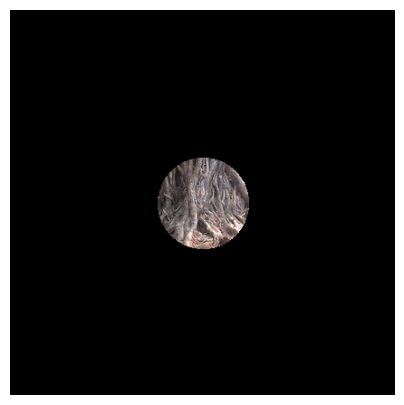

In [10]:
_ = NSP.stimuli.mask_img(16249)

In [4]:
NSP = NatSpatPred()
NSP.initialise(verbose=True)
rl = Reloader()

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [15]:
rois, roi_masks, viscortex_masks = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

In [28]:
NSP.utils.inspect_dat(df['betas'])

Lowest value: -0.0361284318493508
Highest value: 0.1697873665737728
Mean value: 0.01824382341730934
Standard deviation: 0.017869671823805063


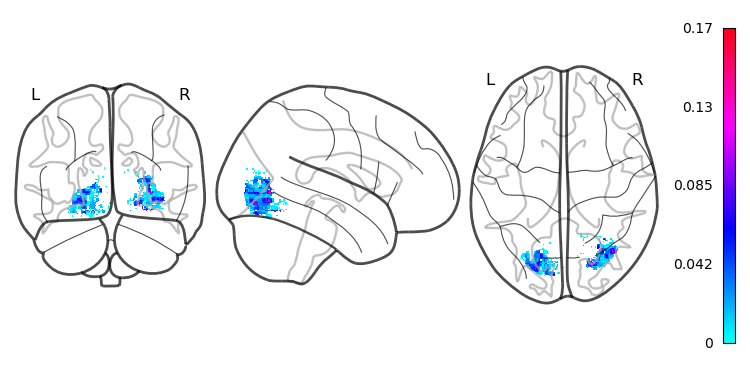

In [27]:

subject = "subj01"

df = pd.read_csv(f"{NSP.own_datapath}/{subject}/results/unpred/vgg-b_lay0_regdf.csv")

# plt.plot(df['betas'])


beta_coords = df[['x','y','z','betas']].values

beta_coords

NSP.analyse.stat_on_brain(prf_dict=prf_dict,
                          roi_masks=roi_masks,
                          subject=subject,
                          stat=df['betas'].values,
                          xyzs=df[['x','y','z']].values,
                          glass_brain=True,
                          cmap="hsv")

In [1]:
n_patches = 6
def get_angle_step(n_patches):
    # patch_sequence = [(patch * (360 / n_patches)) for patch in list(range(0, n_patches))]
    patch_sequence = [(patch * (360 / n_patches) + 90) % 360 for patch in range(n_patches)]

    return patch_sequence

peri_angles = get_angle_step(n_patches)

print(peri_angles)

[90.0, 150.0, 210.0, 270.0, 330.0, 30.0]


Now working on patch with angle 90.0
V1 voxels that fulfill requirements: 71 out of 7887.
V2 voxels that fulfill requirements: 89 out of 8296.
V3 voxels that fulfill requirements: 18 out of 7022.
V4 voxels that fulfill requirements: 15 out of 3976.
Now working on patch with angle 150.0
V1 voxels that fulfill requirements: 94 out of 7887.
V2 voxels that fulfill requirements: 114 out of 8296.
V3 voxels that fulfill requirements: 24 out of 7022.
V4 voxels that fulfill requirements: 3 out of 3976.
Now working on patch with angle 210.0
V1 voxels that fulfill requirements: 201 out of 7887.
V2 voxels that fulfill requirements: 26 out of 8296.
V3 voxels that fulfill requirements: 28 out of 7022.
V4 voxels that fulfill requirements: 14 out of 3976.
Now working on patch with angle 270.0
V1 voxels that fulfill requirements: 31 out of 7887.
V2 voxels that fulfill requirements: 23 out of 8296.
V3 voxels that fulfill requirements: 46 out of 7022.
V4 voxels that fulfill requirements: 12 out of 3976.


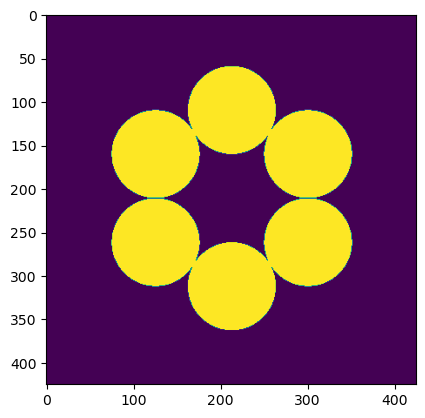

In [52]:
# Perhaps even better to do some sort of matrix multiplication with a boolean mask to to solley select 
# the voxels that are exclusively inside the patch. But this is better to do after having done this selection
# than checking it for every single voxel beforehand.

# Double check whether the peripheral patches are fully vectorised, they take some time still (not much though)

subject = "subj01"
max_size = 2
min_size = 0.15
patchbound = 1
min_nsd_R2 = 0
min_prf_R2 = 0
# peripheral_center = (-2, 2)
# peri_angles = [90, 210, 330]
peri_ecc = 2  #1.2
# fixed_n_voxels = 50


for patch_no, angle in enumerate(peri_angles):
    voxeldict = {}
    print(f"Now working on patch with angle {angle}")
    for roi in rois:
        print_attr = True if roi == rois[len(rois) - 1] else False
        voxeldict[roi] = VoxelSieve(
            NSP,
            prf_dict,
            roi_masks,
            subject=subject,
            roi=roi,
            patchloc="peripheral",
            max_size=max_size,
            min_size=min_size,
            patchbound=patchbound,
            min_nsd_R2=min_nsd_R2,
            min_prf_R2=min_prf_R2,
            print_attributes=False, #print_attr,
            fixed_n_voxels=None,
            peripheral_center=None,
            peri_angle=angle,
            peri_ecc=peri_ecc,
            leniency = 0.25,
            verbose=False
        )
        
    if patch_no == 0:
        mask_stack = voxeldict[roi].patchmask
    else:
        mask_stack = mask_stack + voxeldict[roi].patchmask
        
plt.imshow(mask_stack)

ROI V4 contains 31 voxels
Patch centre at y: 263.5952380952381, and x:300.5297619047619


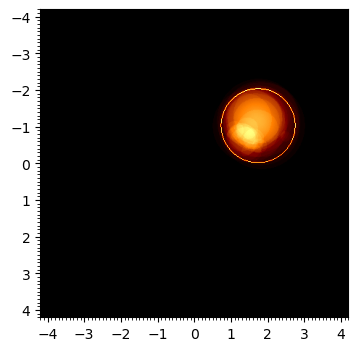

In [53]:
# roi = "V1"
# for roi in rois:
print(f"ROI {roi} contains {len(voxeldict[roi].size)} voxels")
NSP.cortex.plot_prfs(voxeldict[roi], enlarge=False, which_voxels="all", cmap="afmhot")

In [12]:
mask1 = (voxeldict[roi].patchmask)

In [57]:
lgn = rl.lgn(config_file='default_config.yml')

NSP = rl.nsp()
NSP.initialise()

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .attributes_unfiltered
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


{'ecc1.2_angle90': Empty DataFrame
 Columns: [rms, ce, sc]
 Index: [],
 'ecc1.2_angle210': Empty DataFrame
 Columns: [rms, ce, sc]
 Index: [],
 'ecc1.2_angle330': Empty DataFrame
 Columns: [rms, ce, sc]
 Index: []}

Load in the images

In [112]:
n_imgs = 4

imgs, img_nos = NSP.stimuli.rand_img_list(n_imgs = n_imgs,
                                          asPIL = True,
                                          add_masks = False,
                                        #   select_ices = NSP.stimuli.imgs_designmx()["subj01"][:n_imgs])
)

Compute RMS

In [113]:
eccentricity = 1.2
angle = 90
patch_data = pd.DataFrame(columns=['rms', 'ce', 'sc'])

In [114]:
mask = mask1



for img in imgs:

    rms = NSP.stimuli.calc_rms_contrast_lab(
        # rgb_image=np.array(Image.open(img)),
        rgb_image=np.array(img),
        mask_w_in=mask,
        rf_mask_in=mask,
        normalise=True,
        plot=False,
        cmap="gist_gray",
        crop_post=False,
        lab_idx=0,
        cropped_input=False)
    
    ce, sc, _,_,_,_,_ = NSP.stimuli.get_scce_contrast(np.array(img),
                                plot="n",
                                cmap="gist_gray",
                                crop_prior=True,
                                crop_post=False,
                                save_plot=False,
                                return_imfovs=True,
                                imfov_overlay=True,
                                config_path="/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/psybi_cfs_config.yml",
                                lgn_instance=lgn,
                                patch_center=NSP.utils.get_circle_center(mask),
                                deg_per_pixel=(8.4 / 425))

    ce = np.nan_to_num(ce)
    sc = np.nan_to_num(sc)
    
    # features[feature].loc[len(features[feature])] = [rms, ce, sc]
    
    patch_data.loc[len(patch_data)] = [rms, ce, sc]


In [115]:
patch_data

rms        ce        sc
0  18.913477  0.001663  0.968341
1  23.210805  0.000118  0.651817
2  15.446960  0.001816  0.779151
3  11.653643  0.001829  0.568407

In [79]:
NSP.own_datapath

'/home/rfpred/data/custom_files'

In [101]:
patch_data.to_csv(f"{NSP.own_datapath}/visfeats/peripheral/rmsscce_ecc{eccentricity}_angle{angle}.csv")

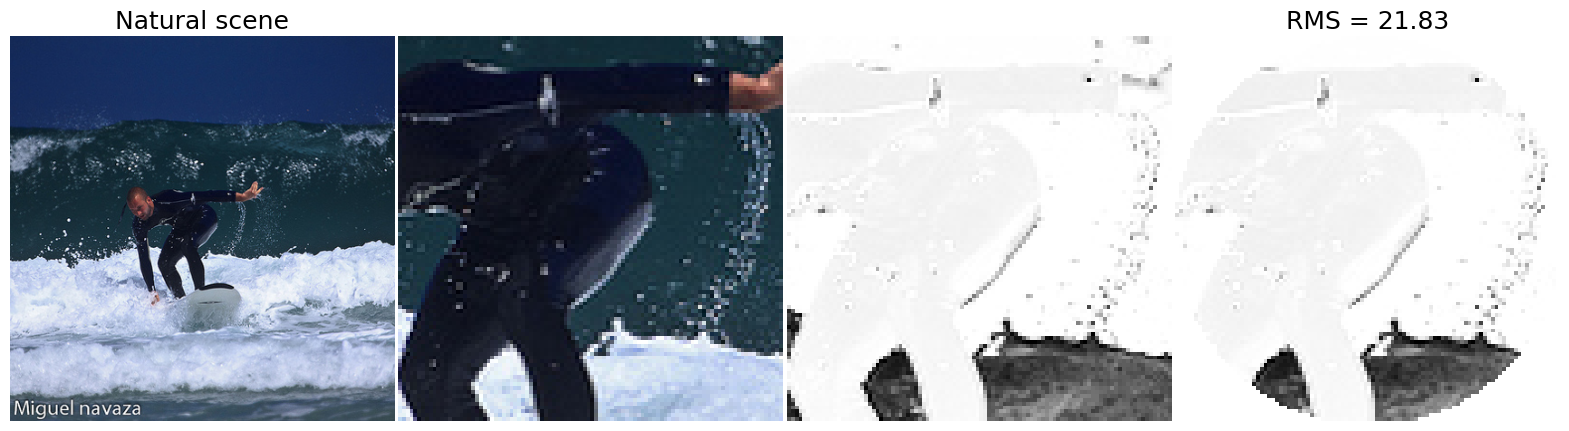

In [65]:
cmask = NSP.utils.make_circle_mask(425, 213, 213, 1 * (425 / 8.4), fill="y", margin_width=1).astype(bool)

# plt.imshow(cmask)

rms = NSP.stimuli.calc_rms_contrast_lab(
    # rgb_image=np.array(Image.open(img)),
    rgb_image=np.array(imgs[2]),
    mask_w_in=cmask,
    rf_mask_in=cmask,
    normalise=True,
    plot=True,
    cmap="gist_gray_r",
    crop_post=False,
    lab_idx=0,
    cropped_input=False)




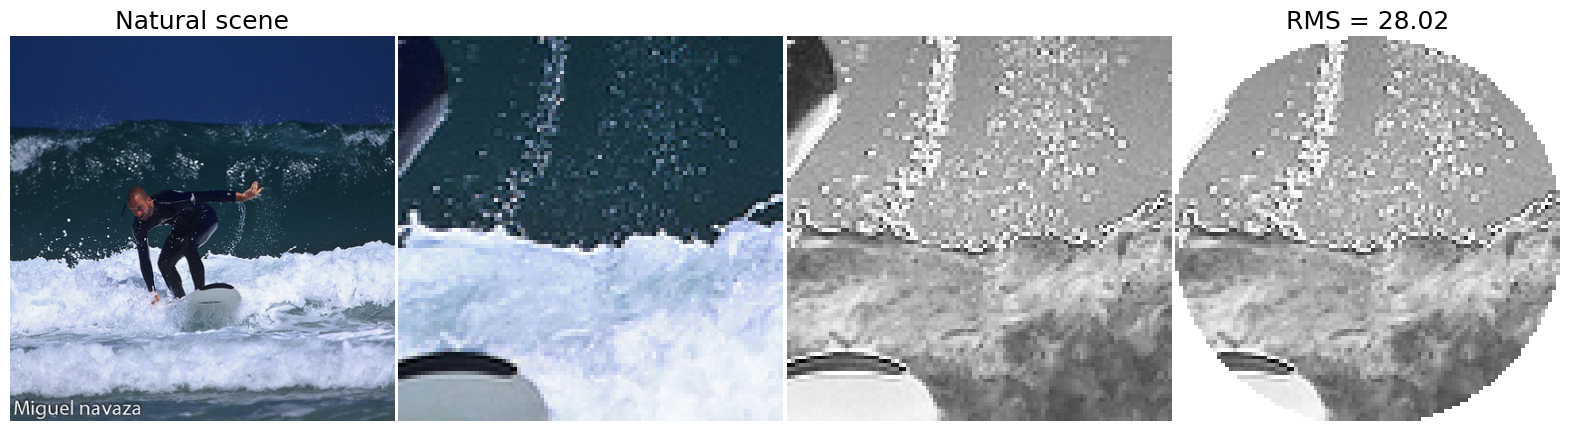

In [66]:
rms = NSP.stimuli.calc_rms_contrast_lab(
    # rgb_image=np.array(Image.open(img)),
    rgb_image=np.array(imgs[2]),
    mask_w_in=mask1,
    rf_mask_in=mask1,
    normalise=True,
    plot=True,
    cmap="gist_gray_r",
    crop_post=False,
    lab_idx=0,
    cropped_input=False)


/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/lgn_statistics.py:683: RuntimeWarning: invalid value encountered in scalar divide
  sc[0,0,0] = np.mean(magnitude) / np.std(magnitude)


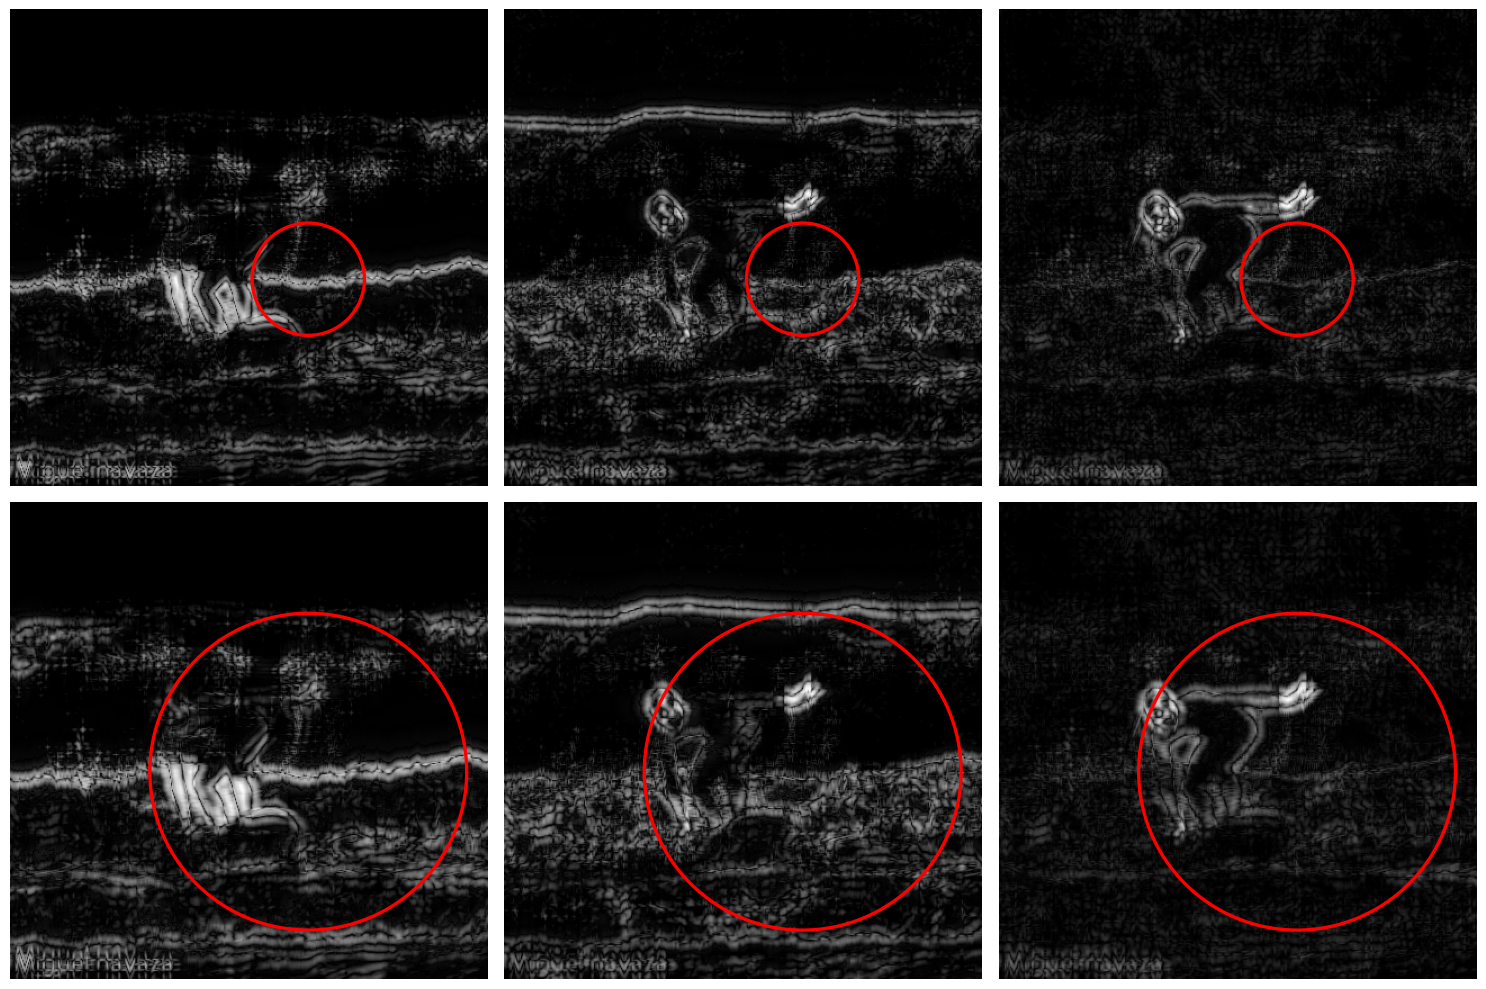

In [69]:
ce, sc, _,_,_,_,_ = NSP.stimuli.get_scce_contrast(np.array(imgs[2]),
                            plot="y",
                            cmap="gist_gray",
                            crop_prior=True,
                            crop_post=False,
                            save_plot=False,
                            return_imfovs=True,
                            imfov_overlay=True,
                            config_path="/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/psybi_cfs_config.yml",
                            lgn_instance=lgn,
                            patch_center=NSP.utils.get_circle_center(mask),
                            deg_per_pixel=(8.4 / 425))

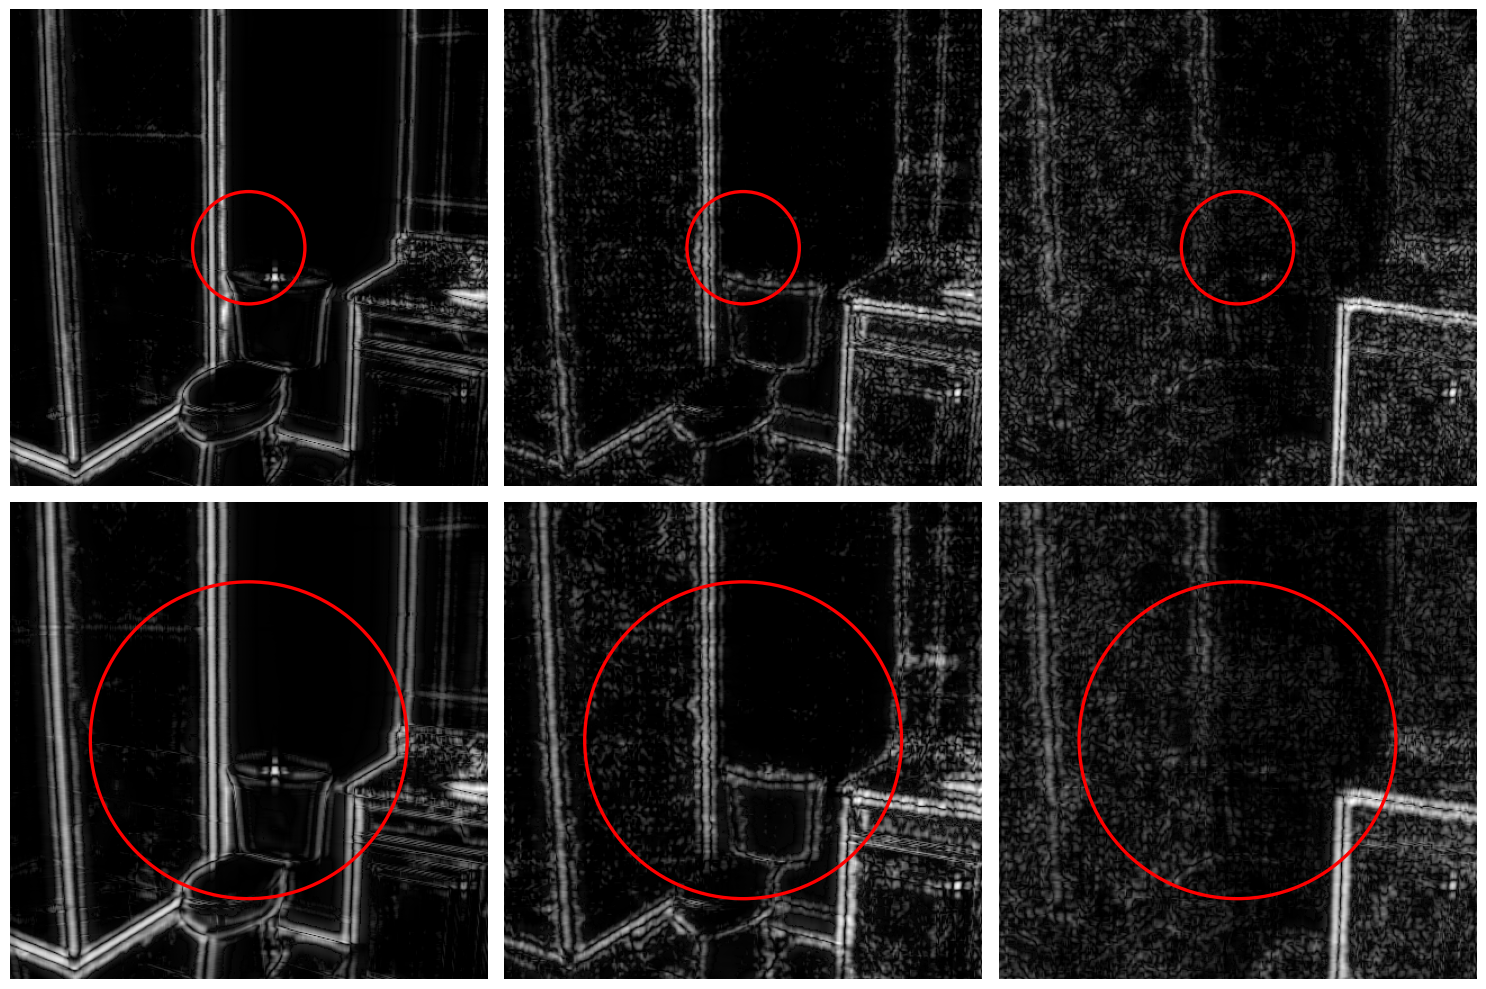

In [49]:
ce, sc, _,_,_,_,_ = NSP.stimuli.get_scce_contrast(np.array(img),
                            plot="y",
                            cmap="gist_gray",
                            crop_prior=True,
                            crop_post=False,
                            save_plot=False,
                            return_imfovs=True,
                            imfov_overlay=True,
                            config_path="/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/psybi_cfs_config.yml",
                            lgn_instance=lgn,
                            patch_center=NSP.utils.get_circle_center(cmask),
                            deg_per_pixel=(8.4 / 425))

In [104]:
imgs, img_nos = NSP.stimuli.rand_img_list(
    n_imgs=2,
    asPIL=True,
    add_masks=False,
    # select_ices=NSP.stimuli.imgs_designmx()["subj01"][:n_imgs],
)


imgs


[<PIL.Image.Image image mode=RGB size=425x425>,
 <PIL.Image.Image image mode=RGB size=425x425>]

### Unpred

In [118]:
def prepare_dat(
    all_imgs: list,
    mask: list,
    img_startstop: (tuple | None)=None,
    specific_imgs: list | None = None,
    ):
    """
    Prepare the data for further processing.

    Args:
        all_imgs (list): List of image paths.
        mask (list): Mask image.
        img_startstop (tuple, optional): Start and stop indices for selecting specific images. Default None
        specific_imgs (list, optional): List of indices of specific images to select. Defaults to None.

    Returns:
        tuple: A tuple containing the prepared image list and mask list.
    """
    if img_startstop is None:
        img_startstop = (0, len(all_imgs))
    
    if specific_imgs is not None:
        all_imgs = [all_imgs[i] for i in specific_imgs]
    else: 
        all_imgs = all_imgs[img_startstop[0]:img_startstop[1]]

    def _jpeg_to_pil(img):
        return Image.fromarray(np.array(Image.open(img)))

    img_list = [(_jpeg_to_pil(plaat)) for plaat in all_imgs]
    n_imgs = len(img_list)
    mask_list = [Image.fromarray(mask)] * n_imgs
    
    return img_list, mask_list

In [ ]:
chunk_size = n_imgs

for img in imgs:

    # Initialize an empty DataFrame to store the results
    df_all = pd.DataFrame()
    
    # Process the images in chunks
    for i in range(0, len(imgs), chunk_size):
        print(f"Processing chunk {i//chunk_size + 1}/{len(imgs)//chunk_size + 1}")
        img_list, mask_list = prepare_dat(imgs[i:i+chunk_size], mask)
        
        estims = NSP.stimuli.comp_unpred(
            cnn_type="vgg-b",
            pretrain_version="places20k",
            eval_mask_factor=np.sqrt(1.2),
            input_imgs=img_list,
            input_masks=mask_list,
            plot_eval_mask=False
        )
        content_losses = {key: value for key, value in estims.items() if "content" in key and "MSE" in key}
        
        df_chunk = add_feats_to_df(ui[f'features_{feat}'][i:i+chunk_size], content_losses, cut_rows=chunk_size)
        
        # Append the results of this chunk to df_all
        df_all = pd.concat([df_all, df_chunk])
    
    # Store the results in ui
    ui[f'features_{feat}'] = df_all      

# Script test, a lot of code 


In [11]:

import os
import sys

os.environ["OMP_NUM_THREADS"] = "10"

import cortex
import re
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import nibabel as nib
import pickle
import torchvision.models as models
import nibabel as nib
import h5py
import copy
import scipy.stats.mstats as mstats
import matplotlib.patches as patches
from PIL import Image
import argparse

os.chdir("/home/rfpred")
sys.path.append("/home/rfpred/")
sys.path.append("/home/rfpred/envs/rfenv/lib/python3.11/site-packages/")
sys.path.append("/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode")

from classes.regdata import RegData
from funcs.reloads import Reloader
from classes.natspatpred import NatSpatPred
from classes.voxelsieve import VoxelSieve
from unet_recon.inpainting import UNet

from funcs.rf_tools import make_circle_mask
from funcs.imgproc import get_bounding_box



In [12]:
eccentricity = 2.0
angle = 90
startimg = 0
endimg = 10

In [14]:
NSP = NatSpatPred()
NSP.initialise(verbose=True)
rl = Reloader()

rois, roi_masks, viscortex_masks = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)


max_size = 2
min_size = 0.15
patchbound = 1
min_nsd_R2 = 0
min_prf_R2 = 0
# peripheral_center = (-2, 2)
peri_angles = [90, 210, 330]
peri_ecc = eccentricity
# fixed_n_voxels = 50


Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [15]:
# This voxeldict is not really needed, but I use it to get the exact matching
# mask for the peripheral patch
voxeldict = {}
print(f"Now working on patch with angle {angle}")
for roi in rois:
    print_attr = True if roi == rois[len(rois) - 1] else False
    voxeldict[roi] = VoxelSieve(
        NSP,
        prf_dict,
        roi_masks,
        subject="subj01",
        roi=roi,
        patchloc="peripheral",
        max_size=max_size,
        min_size=min_size,
        patchbound=patchbound,
        min_nsd_R2=min_nsd_R2,
        min_prf_R2=min_prf_R2,
        print_attributes=False,  # print_attr,
        fixed_n_voxels=None,
        peripheral_center=None,
        peri_angle=angle,
        peri_ecc=peri_ecc,
        leniency=0,
        verbose=False,
    )

mask1 = voxeldict[roi].patchmask

NSP = rl.nsp()
NSP.initialise()

n_imgs = endimg - startimg
print(f"Processing {n_imgs} images, going from {startimg} to {endimg}")
print(f"Patch eccentricity: {eccentricity}, patch angle: {angle}")
select_ices = list(range(startimg, endimg))



Now working on patch with angle 90
V1 voxels that fulfill requirements: 47 out of 7887.
V2 voxels that fulfill requirements: 52 out of 8296.
V3 voxels that fulfill requirements: 7 out of 7022.
V4 voxels that fulfill requirements: 11 out of 3976.
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .attributes_unfiltered
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils
Processing 10 images, going from 0 to 10
Patch eccentricity: 2.0, patch angle: 90


In [16]:
# THIS BELOW IS FROM THE GET_PRED.PY SCRIPT
def draw_circmask(dims, maskrad, offset=(0,0), invert=True):
    import numpy as np
    y, x = np.ogrid[:dims[0], :dims[1]]
    center_x, center_y = dims[1] // 2 + offset[0], dims[0] // 2 + offset[1]
    mask = (x - center_x)**2 + (y - center_y)**2 <= maskrad**2
    return ~mask if invert else mask

mask_radius=100
rf_mask=draw_circmask((425,425),mask_radius)

def rand_img_list(n_imgs, asPIL:bool = True, add_masks:bool = True, mask_loc: str|np.ndarray = 'center', ecc_max = 1, select_ices = None, in_3d:bool = False):
    imgs = []
    img_nos = []
    for i in range(n_imgs):
        img_no = random.randint(0, 27999)
        if select_ices is not None:
            img_no = select_ices[i]
        # img = show_stim(img_no = img_no, hide = 'y')[0]
        img = NSP.stimuli.show_stim(img_no = img_no, hide=True, small=False, crop=False)[0]

        if i == 0:
            dim = img.shape[0]
            radius = ecc_max * (dim / 8.4)

            if type(mask_loc) == str:
                if mask_loc == 'center':
                    x = y = (dim + 1)/2
                elif mask_loc == 'irrelevant_patch':
                    x = y = radius + 10
            elif type(mask_loc) == np.ndarray:
                bounds = NSP.utils.get_bounding_box(mask_loc)
                patch_rad = bounds[1] - bounds[0]
                print(patch_rad)
                x = bounds[0] + patch_rad/2
                y = bounds[2] + patch_rad/2
                
        if asPIL:
            img = Image.fromarray(img)

        imgs.append(img)
        # img_nos.append(Image.fromarray(img_no))
        img_nos.append(img_no)
    mask = (make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0) == 0)
    
    if in_3d:
        mask = _make_img_3d(mask)
    if asPIL:
        mask = Image.fromarray(mask)


    masks = [mask] * n_imgs
    
    if add_masks:
        return imgs, masks, img_nos
    else:
        return imgs, img_nos

def slice_array_with_mask(arr_in, mask_in):
    """
    Slices a 2D array using a 2D boolean mask with a contiguous square of True values.

    :param arr_in: 2D numpy array.
    :param mask_in: 2D boolean numpy array of the same shape as arr_in.
    :return: Sliced section of arr_in corresponding to the True values in mask_in.
    """
    # Find the indices of the mask where the value is True
    rows, cols = np.where(mask_in)
    top_left = (min(rows), min(cols))
    bottom_right = (max(rows), max(cols))

    # Slice the array
    return arr_in[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]

def scale_square_mask(mask_in:np.ndarray, scale_fact=np.sqrt(1.5), mask_val=1, min_size=50):
    """given a square mask, scale width and height with a given factor

    in:
    - mask_in: ndarray, (2d or 3d)
        boolean-type mask image
    - mask_val: float/int/bool (default:1)
        the value to look for as the definition of in the circle of the mask.
    - min_size: int
        minimum size of the square mask.

    out:
    -scaled_mask: ndarray
        like the square input mask, but now with a square outline around the mask
    """
    def _do_scaling(_mask_in:np.ndarray, scale_fact=np.sqrt(2), mask_val=1, min_size=50):
        """inner function doing the actual scaling"""
        mask_out=copy.deepcopy(_mask_in)
        nz_rows,nz_cols=np.nonzero(_mask_in==mask_val)
        nz_r,nz_c=np.unique(nz_rows),np.unique(nz_cols)
        # determine square masks that spans the circle
        width, height = nz_r[-1]-nz_r[0], nz_c[-1]-nz_c[0]

        # make actual spanning mask a bit larger (delta determined by scale_fact or min_size)
        ideal_delta_w = max(np.round(((width*scale_fact) - width)*.5), (min_size - width) // 2)
        ideal_delta_h = max(np.round(((height*scale_fact) - height)*.5), (min_size - height) // 2)

        # Adjust deltas based on mask's proximity to image borders
        delta_w_left = min(ideal_delta_w, nz_c[0])
        delta_w_right = min(ideal_delta_w, mask_out.shape[1] - nz_c[-1] - 1)
        delta_h_top = min(ideal_delta_h, nz_r[0])
        delta_h_bottom = min(ideal_delta_h, mask_out.shape[0] - nz_r[-1] - 1)

        # If mask is near the border, expand on the other side
        if delta_w_left < ideal_delta_w:
            delta_w_right = max(ideal_delta_w * 2 - delta_w_left, delta_w_right)
        if delta_w_right < ideal_delta_w:
            delta_w_left = max(ideal_delta_w * 2 - delta_w_right, delta_w_left)
        if delta_h_top < ideal_delta_h:
            delta_h_bottom = max(ideal_delta_h * 2 - delta_h_top, delta_h_bottom)
        if delta_h_bottom < ideal_delta_h:
            delta_h_top = max(ideal_delta_h * 2 - delta_h_bottom, delta_h_top)

        mask_out[int(nz_r[0]-delta_h_top):int(nz_r[-1]+delta_h_bottom),
                 int(nz_c[0]-delta_w_left):int(nz_c[-1]+delta_w_right)] = mask_val
        # set values to 1, square mask
        return(mask_out)

    # switch dealing with RGB [colmns,rows,colours] vs grayscale images [columns,rows]
    if mask_in.ndim==3:
        mask_scaled=_do_scaling(mask_in[:,:,0],scale_fact=scale_fact, mask_val=mask_val, min_size=min_size)
        return(_make_img_3d(mask_scaled))
    elif mask_in.ndim==2:
        return(_do_scaling(mask_in, scale_fact=scale_fact, mask_val=mask_val, min_size=min_size))
    else:
        raise ValueError('can only understand 3d (RGB) or 2d array images!')

def _make_img_3d(mask_in,):
    """for 2d array, copy to make 3-dimensional"""
    return(np.repeat(mask_in[:,:,np.newaxis],3,axis=2))


In [17]:
unet=UNet(checkpoint_name='pconv_circ-places20k.pth',feature_model='vgg-conv')

imgs, masks, img_nos = rand_img_list(n_imgs, asPIL = True, add_masks = True, mask_loc = mask1, ecc_max = 1, select_ices = select_ices, in_3d = False)


rf_mask_in = mask1
rf_mask_nsd = rf_mask_in == 0
xmin,xmax,ymin,ymax = list(get_bounding_box(rf_mask_in))
crop_mask = rf_mask_in[ymin:ymax, xmin:xmax] == 1

# THIS IS THE ORIGINAL ONE, THE CORRECT CROP
eval_fact=np.sqrt(1.2) # This needs to be in correspondence with the min_size (original eval_fact = 1.5, min_size = 100)

# THIS IS THE FULL IMG FEATUREMAP EVALMASK
# eval_fact=np.sqrt(18)
eval_mask=scale_square_mask(~np.array(masks[0]), min_size=80, scale_fact= eval_fact)



Loading the Model...
Running the inpainting file from /rfpred/src/inpainting.py


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100


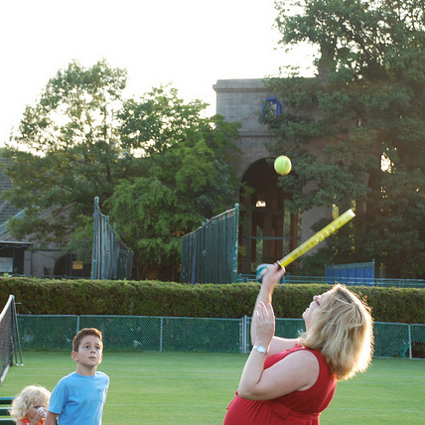

In [22]:
imgs[9]

In [23]:
# Running the shit
start_time = time.time()
 
# Run them through the U-Net
payload_nsd_crop = unet.analyse_images(imgs, masks, return_recons=True, eval_mask = eval_mask)

end_time = time.time()

total_time = end_time - start_time
average_time_per_image = (total_time / n_imgs) #/ 2
print(f'\nThis took {total_time} seconds, or {total_time / 60} minutes, or {total_time / 3600} hours')
print(f"Average time per image: {average_time_per_image} seconds\n")

# Add the specific image indices to the dictionaries. 
payload_nsd_crop['img_ices'] = img_nos

excl = ['recon_dict']
payload_light = {k: v for k, v in payload_nsd_crop.items() if k not in excl}
print("succeeded")






This took 6.068689346313477 seconds, or 0.10114482243855795 minutes, or 0.0016857470406426323 hours
Average time per image: 0.6068689346313476 seconds

succeeded


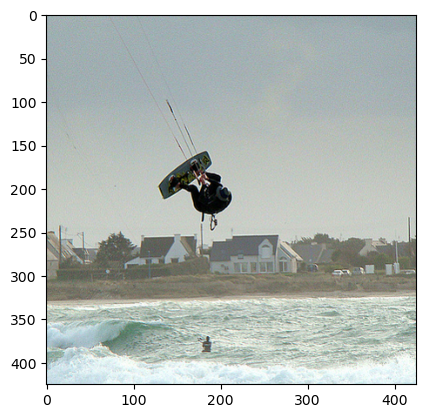

In [51]:
plt.imshow(np.array(imgs[0]))

This is i now: 0
This is i now: 1
This is i now: 2


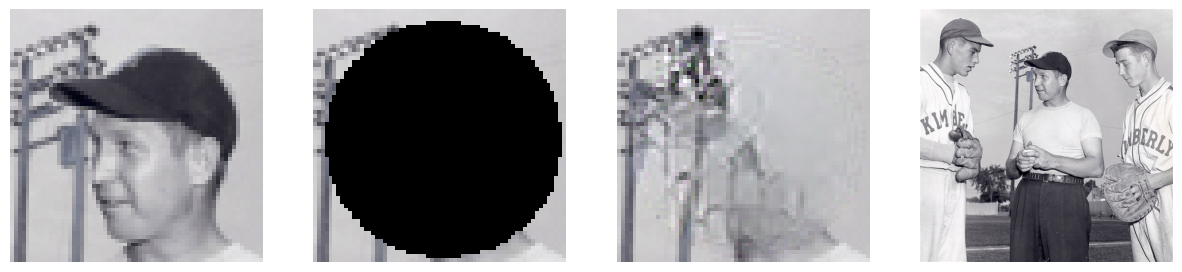

In [65]:
# Here I will inspect whether the inpaintings have actually worked, crucial moment.

# (np.array(payload_nsd_crop['recon_dict']['input_gt'][0]).reshape((65,65,3)))
img_nummer = 6
fig, axes = plt.subplots(1, 4, figsize = (15, 5))
for i, key in enumerate(['input_gt', 'input_masked', 'out_composite']):
    print(f"This is i now: {i}")
    axes[i].imshow(payload_nsd_crop['recon_dict'][key][img_nummer].permute(1, 2, 0))
    if i == 2:
        axes[i+1].imshow(np.array(imgs[img_nummer]))
        axes[i+1].axis('off')

    axes[i].axis('off')


In [ ]:
# Saving the shit

dir_path = f'/home/rfpred/data/custom_files/visfeats/peripheral/ecc{eccentricity}_angle{angle}/pred'
os.makedirs(dir_path, exist_ok=True)

with h5py.File(f'{dir_path}/pred_payloads{startimg}_{endimg}_vggfull.h5', 'w') as hf:
    for key, value in payload_light.items():
        hf.create_dataset(key, data=value)
    print('Light payload saved succesfully')
